In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

import os

/tmp/ipykernel_28912/1754412377.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from pandas import DataFrame

In [3]:
data_path = '../data/raw2'

Read the raw data

In [4]:
failures_path = os.path.join(data_path, 'PdM_failures.csv')
errors_path = os.path.join(data_path, 'PdM_errors.csv')
machines_path = os.path.join(data_path, 'PdM_machines.csv')
maint_path = os.path.join(data_path, 'PdM_maint.csv')
telemetry_path = os.path.join(data_path, 'PdM_telemetry.csv')

In [5]:
failures_df = pd.read_csv(failures_path)
errors_df = pd.read_csv(errors_path)
machines_df = pd.read_csv(machines_path)
maint_df = pd.read_csv(maint_path)
telemetry_df = pd.read_csv(telemetry_path)

Transform `datetime` column

In [6]:
maint_df['datetime'] = pd.to_datetime(maint_df['datetime'], format="%Y-%m-%d %H:%M:%S")
failures_df['datetime'] = pd.to_datetime(failures_df['datetime'], format="%Y-%m-%d %H:%M:%S")
errors_df['datetime'] = pd.to_datetime(errors_df['datetime'], format="%Y-%m-%d %H:%M:%S")
telemetry_df['datetime'] = pd.to_datetime(telemetry_df['datetime'], format="%Y-%m-%d %H:%M:%S")

#### Dataset transformation

Maintenance data

In [7]:
def lifespan(replacement_event_df: DataFrame)->DataFrame:
    
    '''
    Receives a dataframe with timestamp and columns that signify when a component is replaced, with 1.
    Returns a dataframe with the days since the last replacement for the component
    '''
    
    comp_rep=replacement_event_df.copy()
    points = comp_rep['machineID'].unique()
    final=pd.DataFrame()
    
    for i in tqdm(points, desc='Machine'):
        df = comp_rep[(comp_rep['machineID']==i)][['datetime','machineID','comp_comp1', 'comp_comp2', 'comp_comp3', 'comp_comp4']]
        for comp in ['comp_comp1', 'comp_comp2', 'comp_comp3', 'comp_comp4']:
            
            # keep the last part of component name
            life=comp[5:]
            
            #apply function in each row of df[life] column where if row[comp]==1 then value=0.041667 else 0
            df[life] = df.apply(lambda row: 0 if row[comp]==1 else 0.041667, axis=1) # 0.041667 days is 1 hour difference
            df[life] = df[life].cumsum()
            
        final=pd.concat([final,df],axis=0)
        final=final[['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']]
    return final.copy()

In [8]:
maint_transf_df = pd.get_dummies(maint_df, columns=['comp'])
maint_transf_df = telemetry_df.merge(maint_transf_df, on=['datetime', 'machineID'], how='left')
maint_transf_df= maint_transf_df[['datetime', 'machineID', 'comp_comp1', 'comp_comp2', 'comp_comp3', 'comp_comp4']]
maint_transf_df = maint_transf_df.fillna(0)

In [9]:
maintenance_df = lifespan(maint_transf_df)

Machine:   0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
maintenance_df.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,0.041667,0.041667,0.041667,0.041667
1,2015-01-01 07:00:00,1,0.083334,0.083334,0.083334,0.083334
2,2015-01-01 08:00:00,1,0.125001,0.125001,0.125001,0.125001
3,2015-01-01 09:00:00,1,0.166668,0.166668,0.166668,0.166668
4,2015-01-01 10:00:00,1,0.208335,0.208335,0.208335,0.208335


#### Merging the rest of the datasets

In [11]:
#fget dummies for errorID
error_count = pd.get_dummies(errors_df, columns=['errorID'])
error_count.rename(columns={'errorID_error5':'error5count'}, inplace=True)
error_count.rename(columns={'errorID_error4':'error4count'}, inplace=True)
error_count.rename(columns={'errorID_error3':'error3count'}, inplace=True)
error_count.rename(columns={'errorID_error2':'error2count'}, inplace=True)
error_count.rename(columns={'errorID_error1':'error1count'}, inplace=True)

features = telemetry_df.merge(error_count, on=['datetime', 'machineID'], how='left')

# Propagate the error information per error type
features[['error1count','error2count','error3count','error4count','error5count']] = features[['error1count','error2count','error3count','error4count','error5count']].fillna(method='ffill')
# Fill the iinital error count with 0
features = features.fillna(0)

# Add the machine metadata information
features = features.merge(machines_df, on=['machineID'], how='left')

features = features.merge(maint_transf_df, on=['datetime', 'machineID'], how='left')

Merge the failures dataset

In [12]:
fails = pd.get_dummies(failures_df,columns=['failure'])
fails.rename(columns={'failure_comp1':'comp1'}, inplace=True)
fails.rename(columns={'failure_comp2':'comp2'}, inplace=True)
fails.rename(columns={'failure_comp3':'comp3'}, inplace=True)
fails.rename(columns={'failure_comp4':'comp4'}, inplace=True)

In [13]:
def lifespan_fails(comp_rep0):
    comp_rep=comp_rep0.copy()
    points = comp_rep['machineID'].unique()
    final=pd.DataFrame()

    for i in points:
        df = comp_rep[(comp_rep['machineID']==i)][['datetime','machineID','comp1','comp2','comp3','comp4']]
        for comp in ['comp1','comp2','comp3','comp4']:
            life=comp+'_life'
#             prob=comp+'_prob'
#             probkm=comp+'_probkm'
            df[life] = df.apply(lambda row: row['datetime'] if row[comp]==0 else np.nan, axis=1)
            df[df[life].isna()==False].index
            df[life].fillna(method='backfill', inplace=True)
            df[life] = pd.to_datetime(df[life]) - df['datetime']
            df[life] = df[life].apply(lambda row: row.total_seconds()/86400)
#             df[prob] = df[life]/(df[life]+df[comp])
#             df[prob].fillna(1, inplace=True)
#             df[probkm] = 1-1/(df[life]+df[comp])
            #back fill with pad
#             df[probkm]=df[probkm].replace(-np.inf, np.nan)
            
        final=pd.concat([final,df],axis=0)
    return final.copy()

In [14]:
fails_ = telemetry_df.merge(fails, on=['datetime', 'machineID'], how='left')

In [15]:
fails_ = fails_.fillna(method='bfill', limit=24) # fill backward up to 24h if all data, otherwise it must be  7

In [17]:
fails_transf = lifespan_fails(fails_)

In [25]:
# For the individual components that fail , the columns with 0 or 1, after the merge and backfill
fails_transf = fails_transf.fillna(0)

In [26]:
labeled_features = features.merge(fails_transf, on=['datetime', 'machineID'], how='left')
# labeled_features = labeled_features.fillna(method='bfill', limit=24) # fill backward up to 24h if all data, otherwise it must be  7

In [31]:
# # convert "failure" target variables into multiple binary targets 
# # i.e. one per component indicating failure/no failure
# labeled_features['comp1_fail'] = (labeled_features['failure'] == 'comp1').astype(int)
# labeled_features['comp2_fail'] = (labeled_features['failure'] == 'comp2').astype(int)
# labeled_features['comp3_fail'] = (labeled_features['failure'] == 'comp3').astype(int)
# labeled_features['comp4_fail'] = (labeled_features['failure'] == 'comp4').astype(int)

## Exploratory data analysis

Machine age - machine age by model

In [69]:
def plot_boxh_groupby(df, feature_name, by):
    """
    Box plot with groupby
    
    df: DataFrame
    feature_name: Name of the feature to be plotted
    by: Name of the feature based on which groups are created
    """
    df.boxplot(column=feature_name, by=by, vert=False, 
                              figsize=(10, 6))
    plt.title(f'Distribution of {feature_name} by {by}')
    plt.show()
    
    
def plot_histogram(df, attribute, title_name, bins, figsize=(9,3), alpha=1, label=None):
    df[attribute].plot(kind='hist', 
                              bins=bins, 
                              figsize=figsize,
                              alpha=alpha,
                              label=label,
                              title=f'{title_name.title()} distribution')
    
def plot_bar_sortvals(df, attribute, title, figsize=(5,5)):
    df[attribute].value_counts(
                normalize=False, dropna=False).sort_values().plot(
                kind='bar', figsize=figsize, grid=True,
                title=title)

    
def plot_scatter(df, x_axis_attr, y_axis_attr, figsize=(5,5), title=None, legend=None):
    df.plot.scatter(x_axis_attr, y_axis_attr, 
                    figsize=figsize, title=title, 
                    legend=legend)


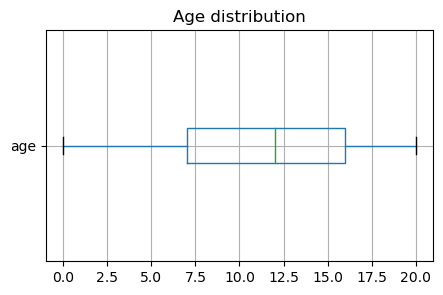

In [34]:
labeled_features.boxplot(column='age', vert=False, figsize=(5,3))
plt.title('Age distribution')
plt.show()


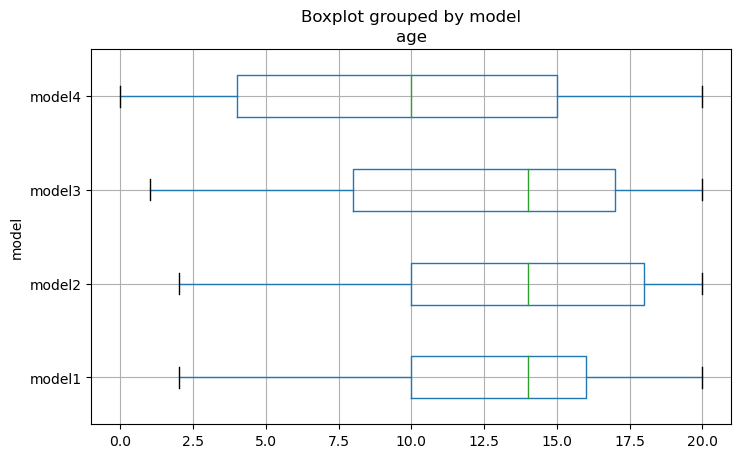

In [35]:
labeled_features.boxplot(column='age', by='model', vert=False, figsize=(8,5))
plt.show()

We can see that `model 4` has the lowest median age

Failure per component

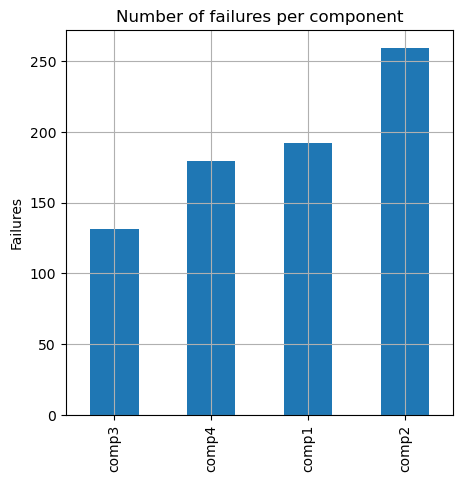

In [68]:
plot_bar_sortvals(failures_df, 'failure', 'Number of failures per component')
plt.ylabel('Failures')
plt.show()

Telemetry data

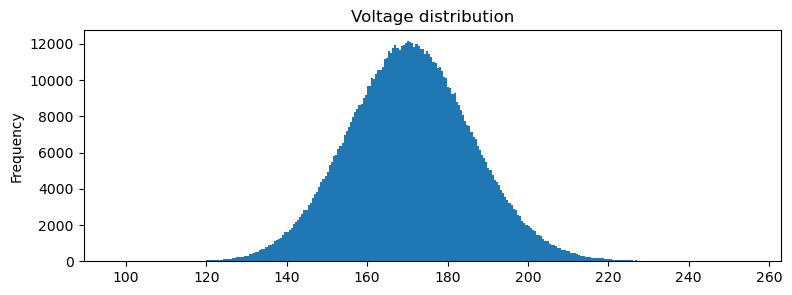

In [37]:
plot_histogram(labeled_features, 'volt', 'Voltage', bins=300)
plt.show()

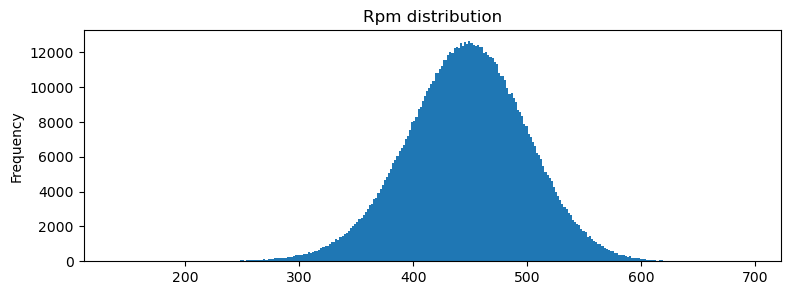

In [38]:
plot_histogram(labeled_features, 'rotate', 'RPM', bins=300)
plt.show()

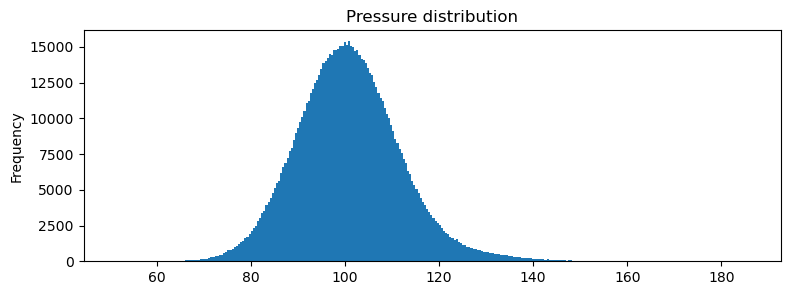

In [39]:
plot_histogram(labeled_features, 'pressure', 'Pressure', bins=300)
plt.show()

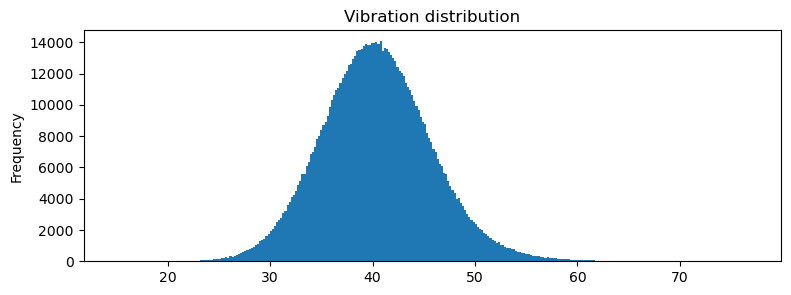

In [40]:
plot_histogram(labeled_features, 'vibration', 'Vibration', bins=300)
plt.show()

All the telemetry data, taking into consideration all machines, look to be normally distributed. The odd one being rotation, which looks a skewed on the left.

/tmp/ipykernel_28912/2248925645.py:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for model in labeled_features.groupby(['model']):


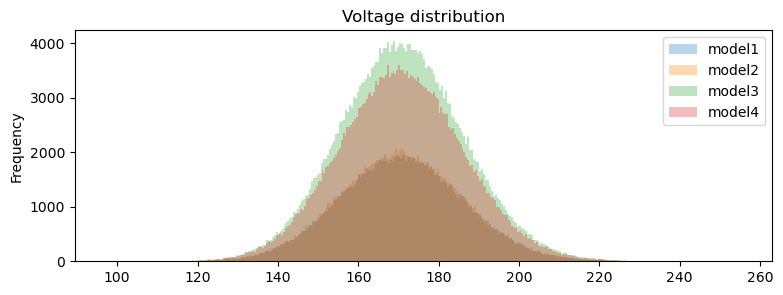

In [41]:
for model in labeled_features.groupby(['model']):
    plot_histogram(model[1], 'volt', 'Voltage',bins=300, alpha=0.3, label=model[0])

plt.legend()
plt.show()

/tmp/ipykernel_28912/3419533908.py:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for model in labeled_features.groupby(['model']):


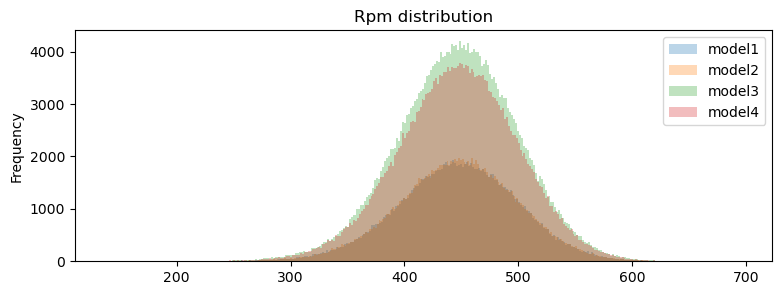

In [42]:
for model in labeled_features.groupby(['model']):
    plot_histogram(model[1], 'rotate', 'RPM',bins=300, alpha=0.3, label=model[0])

plt.legend()
plt.show()

Create a temporary dataframe, which is the `labeled_features` dataframe used in training, but augmented with time features:

Errors

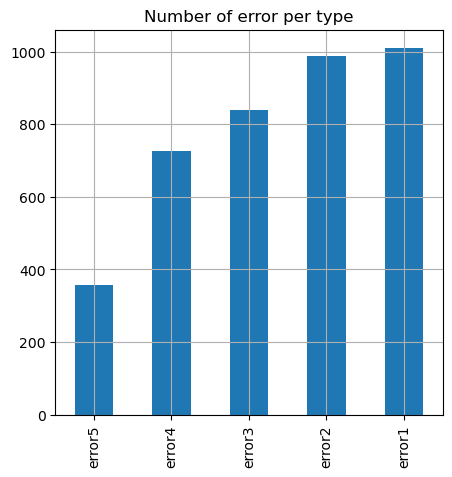

In [55]:
plot_bar_sortvals(errors_df, 'errorID', title='Number of error per type')

plt.show()

The most common error type is 1, while the least common is error 5.

Plot age vs errors

In [72]:
errors_per_machine = errors_df.groupby("machineID").size()
errors_per_machine = pd.DataFrame(errors_per_machine, columns=["num_errors"]).reset_index()

machines_fail_data = pd.merge(machines_df, errors_per_machine, how='left', on="machineID")

maint_per_machine = maint_df.groupby("machineID").size()
maint_per_machine = pd.DataFrame(maint_per_machine, columns=["num_maint"]).reset_index()

machines_fail_data = pd.merge(machines_fail_data, maint_per_machine, how='left', on="machineID")

failure_per_machine = failures_df.groupby("machineID").size()
failure_per_machine = pd.DataFrame(failure_per_machine, columns=["num_failure"]).reset_index()

machines_fail_data = pd.merge(machines_fail_data, failure_per_machine, how='left', on="machineID")

In [89]:
machines_fail_data.fillna(0, inplace=True)

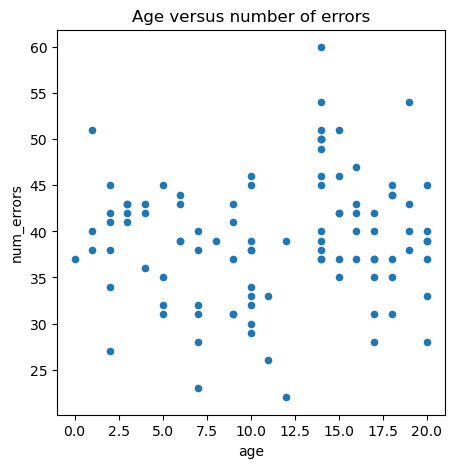

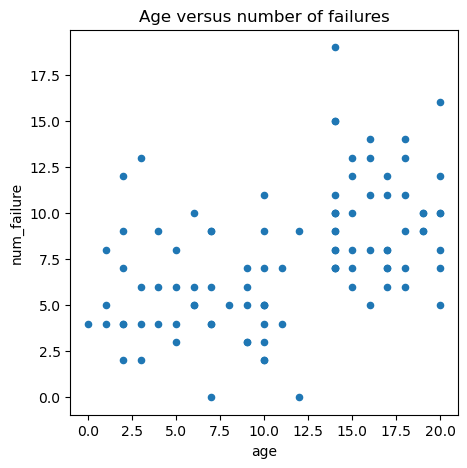

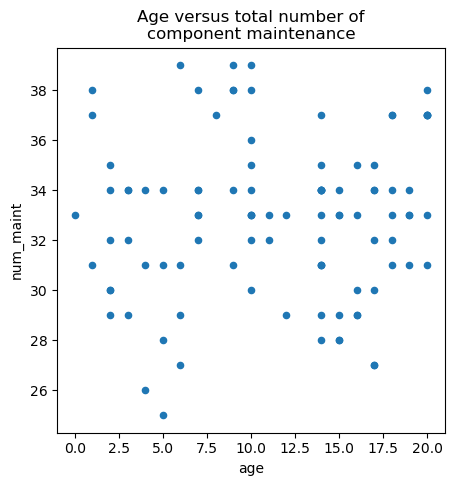

In [90]:
plot_scatter(machines_fail_data, "age", "num_errors", 
             title="Age versus number of errors")

plot_scatter(machines_fail_data, "age", "num_failure", 
             title="Age versus number of failures")

plot_scatter(machines_fail_data, "age", "num_maint", 
             title="Age versus total number of\ncomponent maintenance")

In [94]:
corr = machines_fail_data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/tmp/ipykernel_28912/350905018.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = machines_fail_data.corr()
/tmp/ipykernel_28912/350905018.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,machineID,age,num_errors,num_maint,num_failure
machineID,1.00,0.10,0.11,-0.08,0.10
age,0.10,1.00,0.11,0.08,0.47
num_errors,0.11,0.11,1.00,-0.03,0.54
num_maint,-0.08,0.08,-0.03,1.00,-0.04
num_failure,0.10,0.47,0.54,-0.04,1.00


In [57]:
augmented_features = labeled_features.copy()
augmented_features['month'] = augmented_features.datetime.dt.month
augmented_features['week_of_year'] = augmented_features.datetime.dt.isocalendar().week

augmented_features['hour'] = augmented_features.datetime.dt.hour


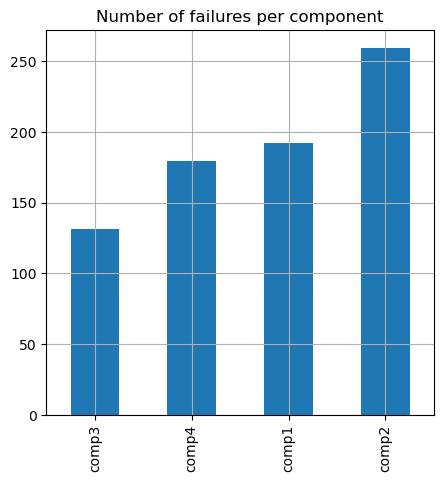

Failures per machine per component

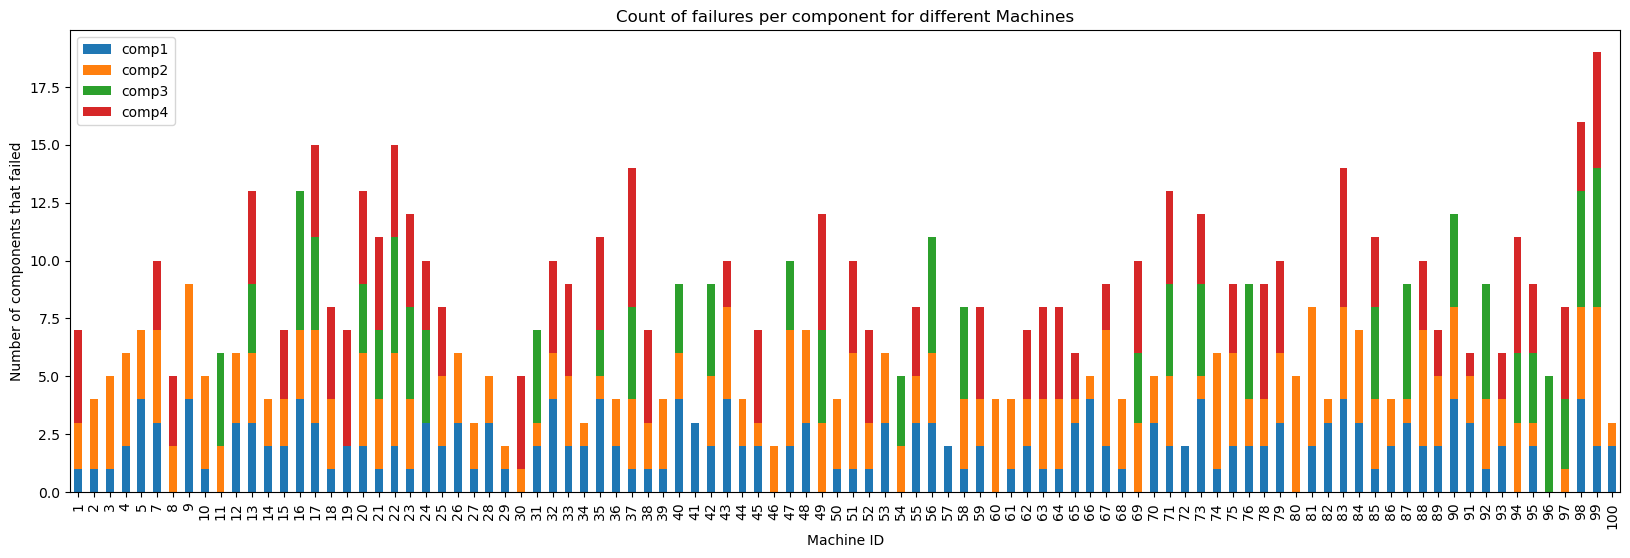

In [101]:
temp_df = failures_df.groupby(["machineID", "failure"]).size().reset_index()
temp_df.columns = ["machineID", "comp", "num_fail"]
temp_df_pivot = pd.pivot(temp_df, index="machineID", columns="comp", values="num_fail").rename_axis(None, axis=1)

temp_df_pivot.plot.bar(stacked=True, figsize=(20, 6), title="Count of failures per component for different Machines")
plt.xlabel("Machine ID")
plt.ylabel("Number of components that failed")

plt.show()

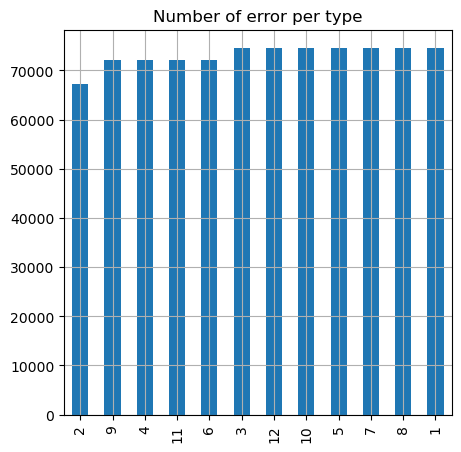

In [103]:
augmented_features['month'].value_counts(
                normalize=False, dropna=False).sort_values().plot(
                kind='bar', figsize=(5,5), grid=True,
                title='Number of error per type')
    
plt.show()